# Goal: 

Explain the canonical label of a work by the motifs within a corpus.

    
# Methodology:

## Model
We use a linear classification technique which takes the following form, $\forall i \in [1, n]$:
$$y_i = \alpha_1 X_{i1} + \alpha_2 X_{i2} + \ldots + \alpha_p X_{ip} + \beta_0C_0 + \ldots + \beta_mC_m = f_{\alpha, \beta}(X, C)$$
where $y$ indicates the where document $i$ is considered canonical (1) or not (0) and $X_i$ is a vector of features computed from motifs of length $p$ for the document $i$, $C = (C_0, \ldots, C_m)$ is a vector of control variables, and $n$ is the number of documents.

Since the canonical label is defined at the author level within our corpus, we need to add these variables to control for the effects that might influence the use of some motifs within specific writings. Our goal is to find the motifs that explain the canonical label, independently from such effects. For example, in the notebook "0_Pipeline_Motifs" we have found that "le NC de" is highly specific to Balzac in "Le Père Goriot". Maybe this motifs is fully explained by the variable "Balzac" who is considered canonical. Thus, a model that does not control for the author variable might conclude that "le NC de" has a strong influence on the canonical label, while "Balzac" might be the variable explaining the canonical label and not the motif itself.

Thus, we include as dummies the author, gender, and publication period as control variables. That way we will find the motifs that explain the canonical aspect of a writing indepently from the author, gender and publication date, focusing only on linguistic features of the writing.

### Pre-selection of features

In this notebook, $p$ is very large ($>200K$), thus we introduce a criterion for feature selection before estimating the parameters. Since we know that a token which as a tfidf of 0 corresponds to non-informative tokens, we propose a simple solution solution based on the sparsity of feature $X_{:,j}$. We define the sparsity level as the proportion of 0 in a vector: $\forall j, \operatorname{S}_j = 1/n\sum_i \operatorname{I}\{X_{i,j} = 0\}$. The more sparse the token is in the corpus, the less informative it is, since it is more common to all documents. Then, we simply select the $P$ less sparse features.


## Estimation

We apply the pipeline in order to obtain the motif annotations (or any other token). Then, we compute the $X_i$ which are defined as the TFIDF scores of each motif within each document in the corpus, where a document represents a window of motifs, as stated above.

To fit the model, we simply minimize the Mean Squarred Error as in a classical logistic regression framework. However, in order to select the most important motifs, we apply the L1 regularization which forces non-informative features to have a 0 coefficient.

## Evaluation


To evaluate the model, we split the data in train/test samples where the observations in the test sample come from documents that are not in the train sample. We keep the class distributions in the train and test equal a Finally, we use the accuracy metric on the test set (as classes are balanced).

# Import librairies

In [33]:
from gensim import corpora
from gensim import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

from motifs.dataloader import CanonData
from motifs.features import bow_to_matrix
from motifs.utils import filter_token_by_freq

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from motifs.pipeline import Pipeline
from motifs.features import build_tfidf, transform_corpus_to_ngrams
from motifs.utils import build_window_corpus, return_to_text_from_token

# Load data

- Get metadata
- Load the 5-grams that were precomputed using a subcorpus of the "canon" corpus.
    - This subcorpus was built by selecting at most 50 texts at random per period, which are defined in `motifs.dataloader.CanonData`, e.g 1800-1826, 1827-1850, 1851-1869, 1870-1899, 1900-1945, 1946-2024.
    - We have in total 217 documents
    - Remove tokens that appear only once in each document in the corpus

In [2]:
NGRAMS_PATH = "/Users/brunospilak/Documents/Sorbonne/PyMotifs/data_backup/ngrams_canon.csv"
METADATA_PATH = "../data/canon/metadata.csv"

In [3]:
# Load 5-grams, about 1.6GB in RAM
t1 = time.time()
ngrams = pd.read_csv(NGRAMS_PATH, index_col=0)
t2 = time.time()
print(f"Done in {t2-t1:.2f} secs")
docs = list(set(ngrams.doc.unique()))

# Remove tokens that appear only once, this can take a while since ngrams has more than 15 Million rows
t1 = time.time()
ngrams = filter_token_by_freq(ngrams, 1, groupby="doc")
t2 = time.time()
print(f"Done in {t2-t1:.2f} secs")

Done in 27.54 secs
Done in 90.07 secs


In [4]:
# Load metadata
metadata = CanonData(METADATA_PATH, ids=docs)
# data = metadata.data.copy()

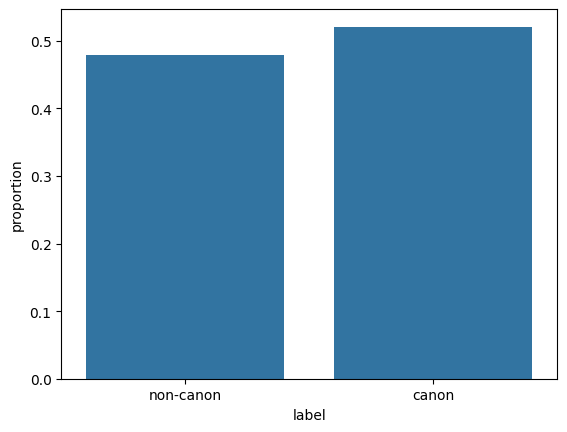

,doc,token,word,text,label
0,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les regards de les agens,non-canon
1,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,le,le nom de le conseil,non-canon
2,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,la,la bienfaisance de le dieu,non-canon
3,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les habitans de le royaume,non-canon
4,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les fers de l' étranger,non-canon
...,...,...,...,...,...
4848684,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC de,serait,serait un vrai coup de,non-canon
4848685,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC que,est,est un charmant garçon que,non-canon
4848686,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC que,est,est un vrai roman que,non-canon
4848687,1971_Veuzit-Max-du_Rien-qu'une-nuit,"être un NC , un",est,"est une bombe , un",non-canon


In [5]:
# Add target variable
sns.countplot(metadata.data, x="label", stat="proportion")
plt.show()
ngrams = ngrams.set_index("doc").join(metadata.data["label"]).reset_index()
ngrams

# Train/test split

We split with respect to the documents, having different document in train and test, but keeping the class distribution in train and test samples.

In [6]:
test_size = 0.3
random_state = 0 # For reproducibility
# Use StratifiedShuffleSplit to keep class balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
train_docs, test_docs = list(sss.split(metadata.data.index, metadata.data.label))[0]
train_docs = metadata.data.index[train_docs].tolist()
test_docs = metadata.data.index[test_docs].tolist()
print(len(train_docs), len(test_docs))

t1 = time.time()
train_motifs = ngrams[ngrams["doc"].isin(train_docs)]
test_motifs = ngrams[ngrams["doc"].isin(test_docs)]
t2 = time.time()
print(f"{t2-t1:.2f}")

151 66
0.57


# Featurization (TFIDF)

As we split the data in train/test, we need to compute the tfidf separately on the two samples. We get the idf on the train set and apply it on the test set, otherwise we would include information from the test set in the train set.

In [7]:
## Train set
t1 = time.time()
train_tfidf, model, dictionary = build_tfidf(train_motifs, normalize=False, smartirs="nfn")
t2 = time.time()
print(f"{t2-t1:.2f}")

# Test set
t1 = time.time()
test_tfidf, _, _ = build_tfidf(test_motifs, model=model, dictionary=dictionary, normalize=False, smartirs="nfn") # Use train_idf
t2 = time.time()
print(f"{t2-t1:.2f}")

47.36
15.85


In [8]:
# Transform to a table with documents as indices and tokens as columns
t1 = time.time()
train_tfidf = train_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")

t1 = time.time()
test_tfidf = test_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")

# In the test set, remove new tokens and add missing ones
if set(train_tfidf.columns) != set(test_tfidf.columns):
    missing_features_in_test = pd.DataFrame(0, columns=list(set(train_tfidf.columns) - set(test_tfidf.columns)), index=test_tfidf.index)
    test_tfidf = pd.concat([test_tfidf, missing_features_in_test], axis=1)
    test_tfidf = test_tfidf[train_tfidf.columns]
    
    missing_features_in_train = list(set(test_tfidf.columns) - set(train_tfidf.columns))
    if len(missing_features_in_train):
        # Remove new features in test set (they are equal to 0 anyway)
        test_tfidf.drop(missing_features_in_train, axis=1, inplace=True)

assert train_tfidf.shape[1] == test_tfidf.shape[1]
(train_tfidf.shape, test_tfidf.shape)

28.65
14.24


((151, 241304), (66, 241304))

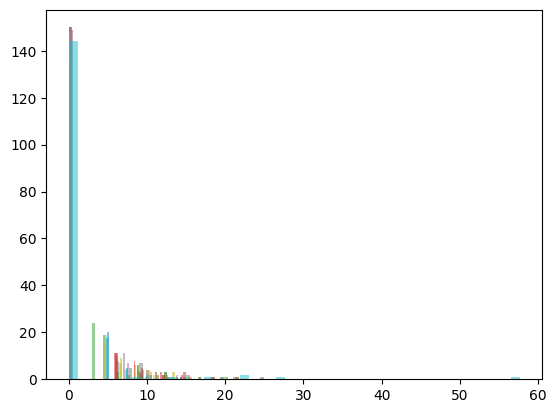

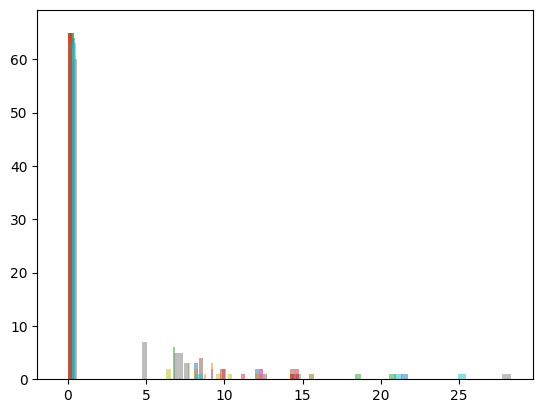

In [9]:
for _ in range(100):
    plt.hist(train_tfidf.iloc[:, np.random.randint(train_tfidf.shape[-1])],
             bins=50, alpha=0.5)
plt.show()
for _ in range(100):
    plt.hist(test_tfidf.iloc[:, np.random.randint(test_tfidf.shape[-1])],
             bins=50, alpha=0.5)
plt.show()

## We obtain more than 200K features, too many! We must introduce a criterion for feature selection.

Since we know that a token which as a tfidf of 0 corresponds to non-informative tokens, we propose a simple solution solution based on the sparsity of each column of the `train_features` matrix. We define the sparsity level as the proportion of 0 in a column of a matrix ($\forall j, \operatorname{S}_j = 1/n\sum_i \operatorname{I}\{M_{ij} = 0\}$ where $n$ is the number of rows in matrix $M$ and $j$ represents a token as column). The more sparse the column of a token, the less informative is the token within the corpus, since it is more common to all documents. Then, we simply select the $n$ less sparse features.

In [24]:
n = 1000
sparsity = (train_tfidf == 0).sum() / len(train_tfidf)
tokens = sparsity.sort_values()[:n].index
selected_train_tfidf = train_tfidf[tokens]
selected_test_tfidf = test_tfidf[tokens]

### TFIDF Normalization

We normalize the TFIDF vectors of each document to have unit norm.

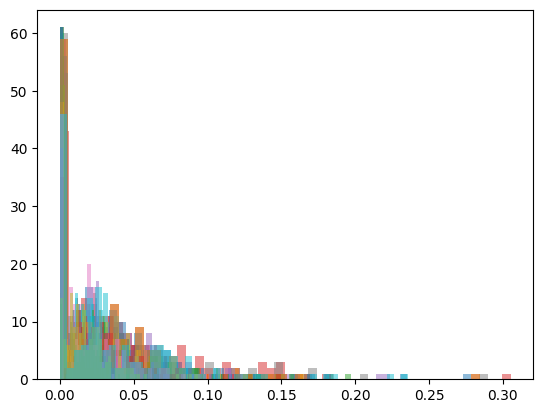

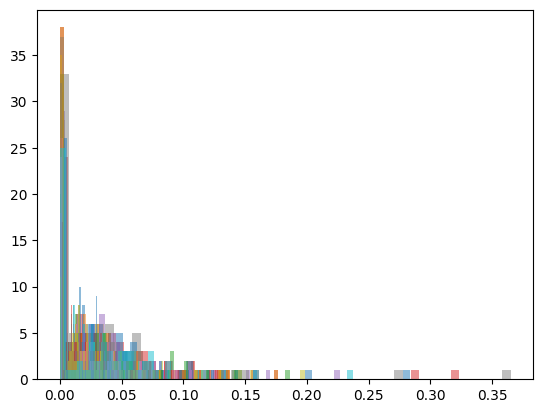

In [25]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer(norm="l2")
selected_train_tfidf = pd.DataFrame(
    normalizer.fit_transform(selected_train_tfidf), 
    columns=tokens,
    index=train_tfidf.index,
)
selected_test_tfidf = pd.DataFrame(
    normalizer.transform(selected_test_tfidf), 
    columns=tokens,
    index=test_tfidf.index,
)

x = []
for _ in range(100):
    i = np.random.randint(len(tokens))
    x.append(i)
    plt.hist(selected_train_tfidf.values[:, i],
             bins=50, alpha=0.5)
plt.show()
for i in range(100):
    plt.hist(selected_test_tfidf.values[:, x[i]],
             bins=50, alpha=0.5)
plt.show()

# Add control variables

We include the *author*, *period*, and *gender* as control variables, encoded as one-hot features, cf `motifs.dataloader.CanonData`.

In [26]:
encoded_cat, encoder = metadata.encode_categories()
# Remove gender variable (included in the author) (mostly)
encoded_cat.drop(["female", "male"], axis=1, inplace=True)

train_x = encoded_cat.loc[train_tfidf.index]
test_x = encoded_cat.loc[test_tfidf.index]

train_x = pd.concat([train_x, selected_train_tfidf], axis=1)
test_x = pd.concat([test_x, selected_test_tfidf], axis=1)
print(train_x.shape, test_x.shape)

(151, 1116) (66, 1116)


# Normalization

We propose to perform a MinMax scaling of the feature in the range [0,1] to ease the interpretation of the regession coefficient.

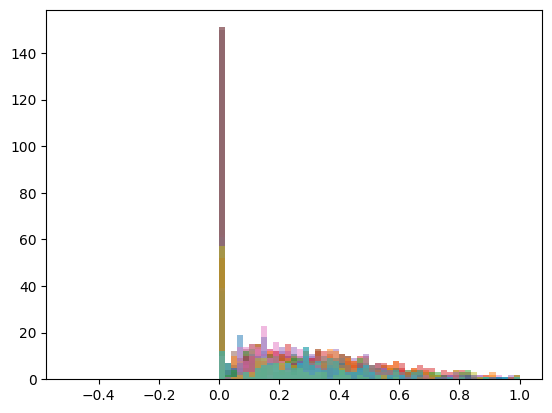

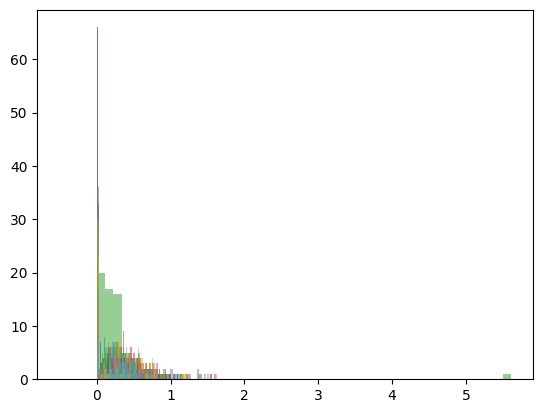

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
train_features = scaler.fit_transform(train_x)
test_features = scaler.transform(test_x)

x = []
for _ in range(100):
    i = np.random.randint(train_features.shape[-1])
    x.append(i)
    plt.hist(train_features[:, i],
             bins=50, alpha=0.5)
plt.show()
for i in range(100):
    plt.hist(test_features[:, x[i]],
             bins=50, alpha=0.5)
plt.show()

# Target variable

In [28]:
train_y = metadata.data.loc[train_tfidf.index, "label"].cat.codes
test_y = metadata.data.loc[test_tfidf.index, "label"].cat.codes

# Fit the model

In [30]:
# Since we have a still a lot of features (1116) compared to the number of observations (151), we propose to use a L1 regularization to select the most important features
# It introduces one hyperparameter: C (the strength of the penalty).
# It will force many parameters to be 0, which introduce sparsity in the solution, thus it is easier to interpret
clf = LogisticRegression(solver='liblinear', penalty='l1', C=0.9, random_state=random_state)
clf.fit(train_features, train_y)

print("Train accuracy", clf.score(train_features, train_y) * 100)
print("Test accuracy", clf.score(test_features, test_y) * 100)
print("Sparisty", np.mean(clf.coef_ == 0) * 100)

Train accuracy 98.67549668874173
Test accuracy 71.21212121212122
Sparisty 96.05734767025089


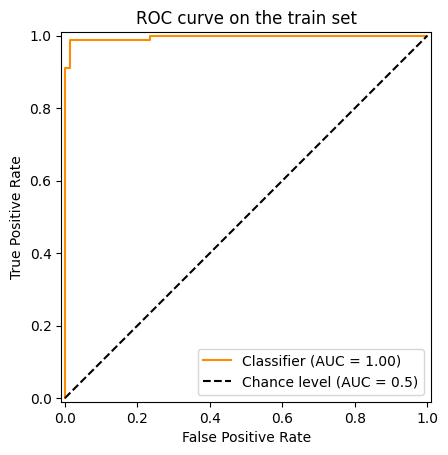

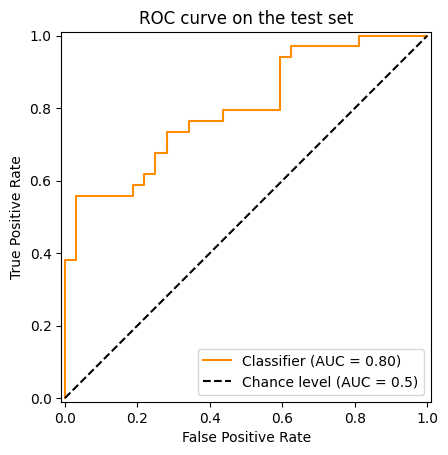

In [31]:
train_y_proba = clf.predict_proba(train_features)
display = RocCurveDisplay.from_predictions(
    train_y,
    train_y_proba[:, 1],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve on the train set",
)

test_y_proba = clf.predict_proba(test_features)
display = RocCurveDisplay.from_predictions(
    test_y,
    test_y_proba[:, 1],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve on the test set",
)

We obtain an accuracy of 71% on the test set showing that we can classify realtively well whether a document is a canon or not based on the motifs and metadata. The classifier does not perfectly predict the target variable on the train set, probably because of the L1 regularization.

On top the ROC curves and AUC of 0.80 on the set show that the predicted probability scores are relatively well calibrated. Since the classes are balanced, the default probability class threshold of 0.5 is likely a good choice.

# Features' importance

44


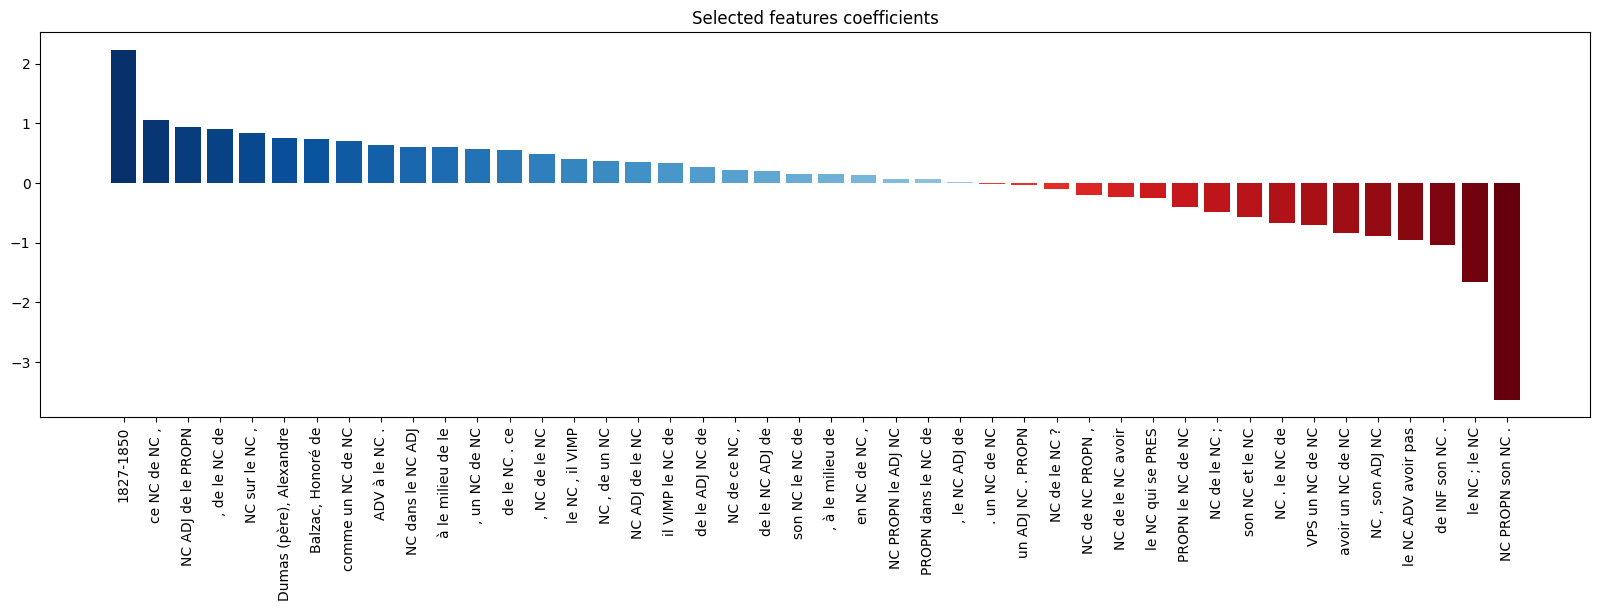

In [32]:
coefs = pd.Series(clf.coef_[0,:], index=train_x.columns)
selected_features = coefs[coefs != 0].sort_values(ascending=False)
print(len(selected_features))
# Separate positive and negative values
positive_values = [val if val > 0 else 0 for val in selected_features]
negative_values = [val if val < 0 else 0 for val in selected_features]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20,5))

# Plot positive values with varying shades of blue
ax.bar(range(len(positive_values)), positive_values, color=plt.cm.Blues(np.linspace(0, 1, len(positive_values)))[::-1])

# Plot negative values with varying shades of red
ax.bar(range(len(negative_values)), negative_values, color=plt.cm.Reds(np.linspace(0, 1, len(negative_values))))

# Customize the plot
ax.set_xticks(range(len(selected_features)))
ax.set_xticklabels(selected_features.index, rotation=90)
ax.set_title("Selected features coefficients")
plt.show()

The lasso has selected 44 features: some motifs but also 2 authors (A. Dumas (père) and H. de Balzac), and 1 period (1827-1850).

In our corpus, writings by A. Dumas and H. de Balzac are more likely to be regarded as canonical compared to those of other authors.

On top, the period 1827-1850 has a strong positive impact on the target.

Let us remember that these interpretations are based on correlation only which cannot be extrapolated as causation. A priori, the period of the publication should not have an impact on the canonical aspect of a writing.

The two most important motifs for the canon label are "ce NC de NC," and "NC ADJ de le PROPN", while the two most important motifs for the non-canon label are "le NC; le NC" and "NC PROPN son NC .".

# Error analysis

It seems that the type I and II errors are well balanced:

In [37]:
print(classification_report(test_y, test_y_pred))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69        32
           1       0.70      0.76      0.73        34

    accuracy                           0.71        66
   macro avg       0.71      0.71      0.71        66
weighted avg       0.71      0.71      0.71        66



In [38]:
test_y_pred = clf.predict(test_features)
correct = test_y.index[test_y_pred == test_y]
errors = test_y.index[test_y_pred != test_y]

The sparsity of the features within the correct prediction and wrong prediction seems also similar:

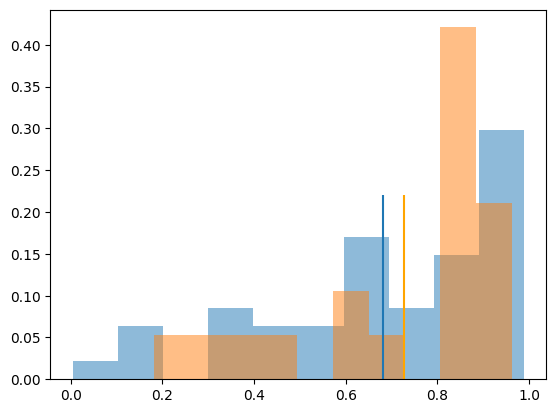

In [40]:
plt.hist(
    (selected_test_tfidf.loc[correct] != 0).sum(axis=1) / selected_test_tfidf.shape[-1], 
    alpha=0.5, 
    weights=np.ones(len(correct)) / len(correct)
)
plt.vlines(np.mean((selected_test_tfidf.loc[correct] != 0).sum(axis=1) / selected_test_tfidf.shape[-1]), 0, 0.22)

plt.hist(
    (selected_test_tfidf.loc[errors] != 0).sum(axis=1) / selected_test_tfidf.shape[-1],
    alpha=0.5,
    weights=np.ones(len(errors)) / len(errors)
)
plt.vlines(np.mean((selected_test_tfidf.loc[errors] != 0).sum(axis=1) / selected_test_tfidf.shape[-1]), 0, 0.22, 
           color="Orange")

## FP/FN

In [45]:
fp = test_y.index[(test_y_pred==1) & (test_y==0)]
fn = test_y.index[(test_y_pred==0) & (test_y==1)]
metadata.data.loc[fp]

,titre,author,gender,birth_date,death_date,date_publication,label,period
doc,,,,,,,,
1833_Corbiere-Edouard_La-mer-et-les-marins-Scenes-maritimes,La mer et les marins. Scènes maritimes,"Corbière, Édouard",male,1793,1875,1833,non-canon,1827-1850
1839_Karr-Alphonse_Clotilde,Clotilde,"Karr, Alphonse",male,1808,1890,1839,non-canon,1827-1850
1846_Lacombe-Patrice_La-terre-paternelle,La terre paternelle,"Lacombe, Patrice",male,1807,1863,1846,non-canon,1827-1850
1862_Erckmann-Chatrian_Contes-des-bords-du-Rhin,Contes des bords du Rhin,"Erckmann, Émile",male,1822,1899,1862,non-canon,1851-1869
1863_Erckmann-Chatrian_Madame-Therese-ou-Les-Volontaires-de-92-Pourquoi-Hunebourg-ne-fut-pas-rendu,Madame Thérèse ou Les Volontaires de 92 - Pour...,"Chatrian, Alexandre",male,1826,1890,1863,non-canon,1851-1869
1878_Gaboriau-Emile_Le-capitaine-Coutanceau,Le capitaine Coutanceau,"Gaboriau, Émile",male,1832,1873,1878,non-canon,1870-1899
1881_Buet-Charles_Histoires-a-dormir-debout,"Histoires à dormir debout, par Charles Buet (1...","Buet, Charles",male,1846,1897,1881,non-canon,1870-1899
1886_Arene-Paul_Contes-de-Provence,Contes de Provence,"Arène, Paul",male,1886,1886,1887,non-canon,1870-1899
1906_Le-Rouge-Gustave_La-Reine-des-elephants,La Reine des éléphants,"Le Rouge, Gustave",male,1867,1938,1906,non-canon,1900-1945


From the metadata, it is difficult to interpret the False Positives. We notice that they are all writen by male authors, but we know that the male authors are overrepresented in the corpus.

In [51]:
metadata.data.loc[fn]

,titre,author,gender,birth_date,death_date,date_publication,label,period
doc,,,,,,,,
1823_Duras-Claire-de-Durfort_Ourika,Ourika,"Duras, Claire (de)",female,1777,1828,1823,canon,1800-1826
1837_Sand-George_Mauprat,Mauprat,"Sand, George",female,1804,1876,1837,canon,1827-1850
1855_Sand-George_Kourroglou,Kourroglou,"Sand, George",female,1804,1876,1855,canon,1851-1869
1863_Verne-Jules_Cinq-Semaines-en-ballon,Cinq Semaines en ballon,"Verne, Jules",male,1828,1905,1863,canon,1851-1869
1883_Renan-Ernest_Souvenirs-d'enfance-et-de-jeunesse_remastered,Souvenirs d'enfance et de jeunesse,"Renan, Ernest",male,1823,1892,1883,canon,1870-1899
1911_Apollinaire-Guillaume_Les-exploits-d-un-jeune-don-Juan,Les exploits d’un jeune don Juan,"Apollinaire, Guillaume",male,1880,1918,1911,canon,1900-1945
1926_Bourget-Paul_Le-danseur-mondain,Le danseur mondain,"Bourget, Paul",male,1852,1935,1926,canon,1900-1945
1927_Gide-Andre_Les-Faux-monnayeurs,Les Faux-monnayeurs,"Gide, André",male,1869,1951,1925,canon,1900-1945


From the metadata, it is difficult to interpret the False Negatives, however we notice three documents written by female authors.